## visualize sparsity

In [1]:
from SNIP_GAN import SNIP_GAN

2023-01-31 13:06:42.415209: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import tensorflow as tf 
from ArchGan import load_network
with tf.device('/gpu:1'):
    (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
    train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
    train_images = (train_images-127.5)/127.5

    BUFFER_SIZE = 60000
    BATCH_SIZE = 200
    # Batch and shuffle the data
    train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    #load model
    datasource = 'mnist'
    arch = 'dcgan_mnist'
    latent_dim = 100
    initializer1 = tf.initializers.variance_scaling()
    initializer2 = tf.initializers.variance_scaling()
    model = load_network(datasource, arch, latent_dim,BATCH_SIZE, initializer1, initializer2)
    #load pruned weights
    target_sparsity = 0.9
    batchtype = 'equal'
    final_w_disc, mask_disc, final_w_gen, mask_gen = SNIP_GAN(model, target_sparsity, BATCH_SIZE, batchtype)

2023-01-31 13:06:45.790378: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-31 13:06:45.791902: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-31 13:06:45.819551: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2023-01-31 13:06:45.819840: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:af:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2023-01-31 13:06:45.819858: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-01-31 13:0

In [6]:
#build_generator
generator = model.make_layers_gen(final_w_gen, mask_gen)
#build discriminator
discriminator = model.make_layers_disc(final_w_disc, mask_disc)



In [3]:
import functools
def get_sparsity_of_layers(weight):
    keylist = weight.keys()
    sparsity_layer_dic = {}
    for key in keylist:
        num_all_parameter = functools.reduce(lambda x, y: x*y, weight[key].shape)
        nonzero_parameter = tf.math.count_nonzero(weight[key]).numpy()
        zero_parameter = num_all_parameter - nonzero_parameter
        percent_of_sparsity = round((zero_parameter/num_all_parameter) * 100, 1)
        sparsity_layer_dic[key] = percent_of_sparsity
    return sparsity_layer_dic

In [16]:
def get_sparsity_of_layers(weight):
    keylist = weight.keys()
    sparsity_layer_dic = {}
    for key in keylist:
        num_all_parameter = functools.reduce(lambda x, y: x*y, weight[key].shape)
        nonzero_parameter = tf.math.count_nonzero(weight[key]).numpy()
        zero_parameter = num_all_parameter - nonzero_parameter
        percent_of_sparsity = round((zero_parameter/num_all_parameter) * 100, 1)
        sparsity_layer_dic[key] = percent_of_sparsity
    return sparsity_layer_dic

In [4]:
def get_labels(sparsitydic, net):
  keylist = list(sparsitydic.keys())
  labels =[]
  for key in keylist:
    labels.append(key + '_' + net)
  return labels

In [5]:
sparsitydic_disc = get_sparsity_of_layers(final_w_disc)
sparsitydic_gen = get_sparsity_of_layers(final_w_gen)
sparsitydic_disc, sparsitydic_gen

({'w1_conv': 24.6,
  'w2_conv': 73.2,
  'w3_conv': 84.4,
  'w4_conv': 92.8,
  'w5_fc': 24.5},
 {'w1_fc': 99.9,
  'w2_Dconv': 88.8,
  'w3_Dconv': 73.2,
  'w4_Dconv': 46.4,
  'w5_Dconv': 11.0})

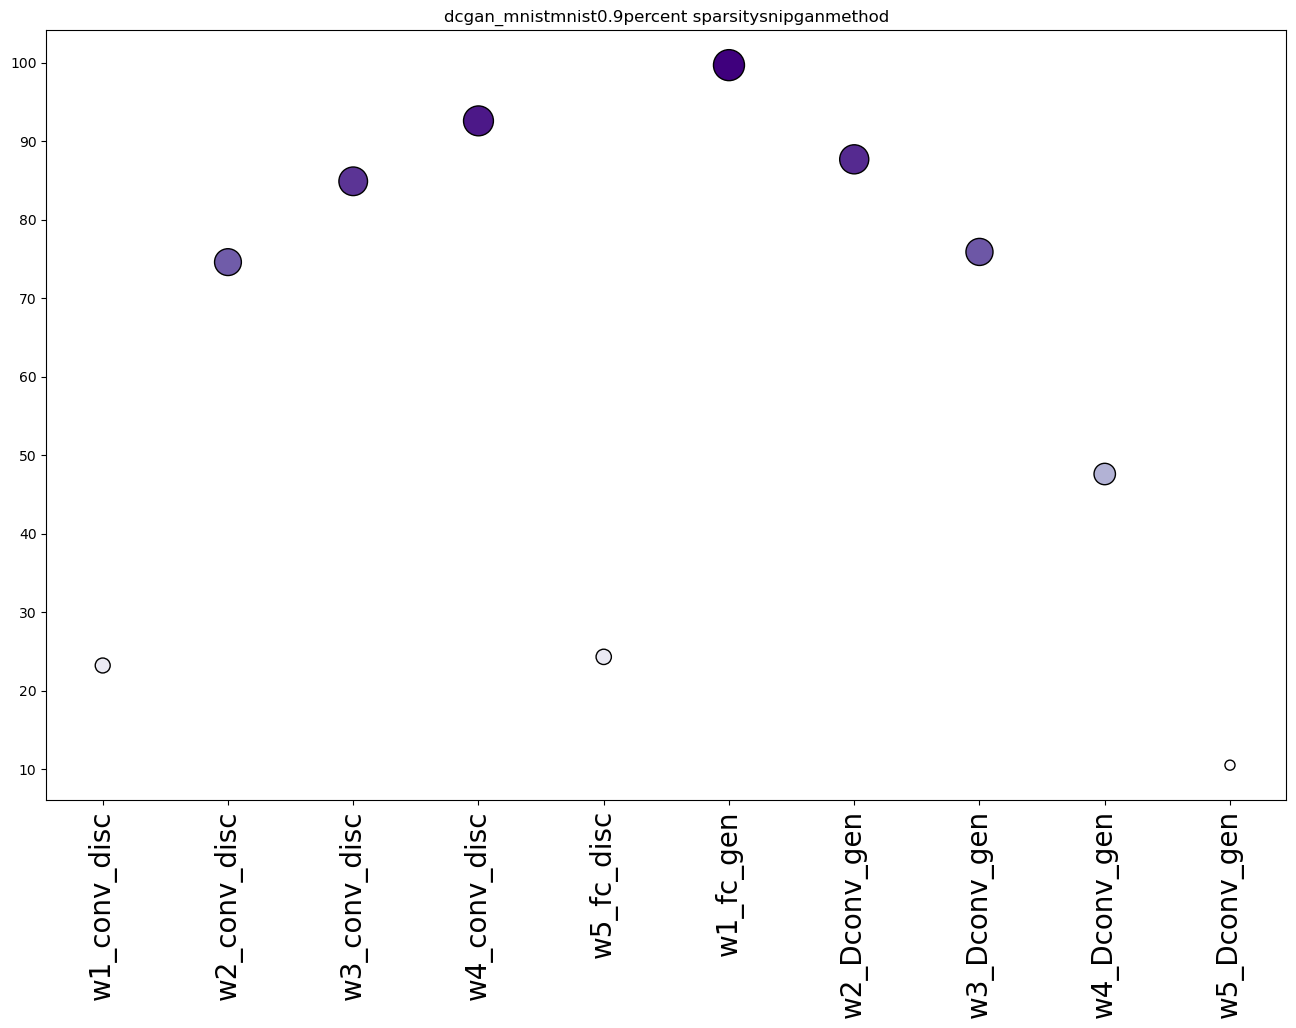

In [28]:
import numpy as np
import copy
import matplotlib.pyplot as plt 
sparsity_percent_values_disc = list(sparsitydic_disc.values())
sparsity_percent_values_gen = list(sparsitydic_gen.values())
sparsity_percent_values = sparsity_percent_values_disc + sparsity_percent_values_gen
keylist_disc = list(sparsitydic_disc.keys())
keylist_gen = list(sparsitydic_gen.keys())
keylist = keylist_disc + keylist_gen
num_layerparameters_disc = len(keylist_disc)
num_layerparameters_gen = len(keylist_gen)
num_layerparameters = num_layerparameters_disc + num_layerparameters_gen
x = np.arange(1, num_layerparameters+1)
y = sparsity_percent_values
sizes = [i*5 for i in y]
labels_disc  = get_labels(sparsitydic_disc, 'disc')
labels_gen  = get_labels(sparsitydic_gen, 'gen')
labels = labels_disc + labels_gen
sizes_copy = copy.deepcopy(sizes)
sizes_copy.reverse()
plt.figure(figsize=(16, 10))
plt.scatter(x, y, s=sizes, cmap = 'Purples', c = sizes, edgecolors='black')
plt.xticks(x, labels, fontsize=20, rotation=90)
plt.yticks(np.arange(10, 110, 10))
title = arch + datasource + str(target_sparsity) + 'percent sparsity' + 'snipgan' + 'method'
plt.title(title)
plt.show()


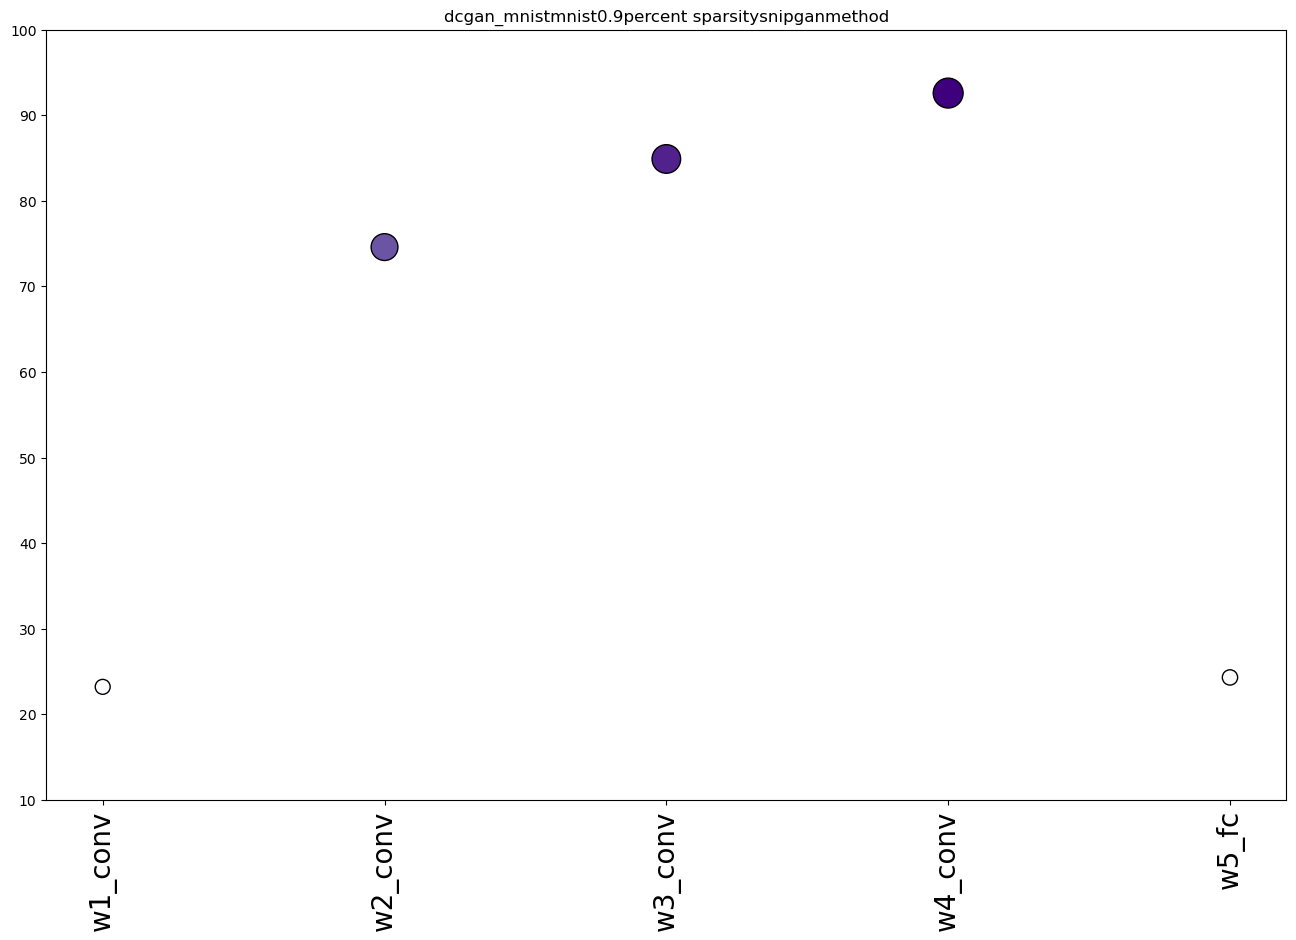

In [18]:
import numpy as np
import copy
import matplotlib.pyplot as plt 
sparsity_percent_values_disc = list(sparsitydic_disc.values())
keylist_disc = list(sparsitydic_disc.keys())
num_layerparameters_disc = len(keylist_disc)
x = np.arange(1, num_layerparameters_disc+1)
y = sparsity_percent_values_disc
sizes = [i*5 for i in y]
labels = keylist_disc
sizes_copy = copy.deepcopy(sizes)
sizes_copy.reverse()
plt.figure(figsize=(16, 10))
plt.scatter(x, y, s=sizes, cmap = 'Purples', c = sizes, edgecolors='black')
plt.xticks(x, labels, fontsize=20, rotation=90)
plt.yticks(np.arange(10, 110, 10))
title = arch + datasource + str(target_sparsity) + 'percent sparsity' + 'snipgan' + 'method'
plt.title(title)
plt.show()

### Inception Score example

In [4]:
# conditional probabilities for high quality images
import numpy as np
p_yx = np.asarray([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])

In [5]:
p_y = np.expand_dims(p_yx.mean(axis=0), 0)

In [6]:
p_y

array([[0.33333333, 0.33333333, 0.33333333]])

In [7]:
eps=1E-16

In [8]:
# kl divergence for each image
kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))

In [9]:
# sum over classes
sum_kl_d = kl_d.sum(axis=1)
# average over images
avg_kl_d = np.mean(sum_kl_d)
is_score = tf.math.exp(avg_kl_d)

In [ ]:
is_score

In [8]:
kl_d

array([[ 1.09861229, -0.        , -0.        ],
       [-0.        ,  1.09861229, -0.        ],
       [-0.        , -0.        ,  1.09861229]])

In [1]:
from Data import Dataset
dat = Dataset('mnist')

2023-01-15 17:15:44.684643: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Test

In [1]:
from utils import get_config_from_json

configs, _ = get_config_from_json('./config/VGG/config_test.json')

In [2]:
from Data import Dataset, generate_tensordata
from Arch import load_network
import tensorflow as tf

2023-01-28 00:29:49.429830: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
initializerdic = {'varianceScaling': tf.initializers.variance_scaling(), 'HeNormal': tf.keras.initializers.HeNormal()}
batch_size = configs.batch_size
batch_size_for_prune = configs.batch_size_for_prune
datasource = configs.datasource
optimizer = configs.optimizer
lr_decay_type = configs.lr_decay_type
learning_rate = configs.learning_rate
boundaries = configs.boundaries
values = configs.values
train_iterations = configs.train_iterations
arch = configs.arch
initializer1= initializerdic[configs.initializer_conv]
initializer2= initializerdic[configs.initializer_dense]
#pruning_method = configs.pruning_method
batchtype = configs.batchtype
target_sparsity = configs.target_sparsity
prune_epoch = configs.pruning_epoch
experiment = configs.experiment


tensordata_train = generate_tensordata(datasource, 'train')
tensordata_val = generate_tensordata(datasource, 'val')
tensordata_test = generate_tensordata(datasource, 'test')

dat = Dataset(datasource)
num_classes = dat.num_classes

model = load_network(datasource, arch, num_classes, initializer1, initializer2)
weights = model.construct_weights(True)

2023-01-28 00:29:55.041801: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-28 00:29:55.042700: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-28 00:29:55.070756: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2023-01-28 00:29:55.071137: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:af:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2023-01-28 00:29:55.071164: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-01-28 00:2

In [4]:
from SNIP import SNIP
with tf.device('/gpu:1'):
   final_mask, final_weight = SNIP(model, target_sparsity, batch_size_for_prune, batchtype)
   net = model.make_layers(final_weight)

2023-01-28 00:30:05.877196: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-01-28 00:30:07.016444: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


In [5]:
final_mask.keys()

dict_keys(['w1_conv', 'w2_conv', 'w3_conv', 'w4_conv', 'w5_conv', 'w6_conv', 'w7_conv', 'w8_conv', 'w9_conv', 'w10_conv', 'w11_conv', 'w12_conv', 'w13_conv', 'w14_fc', 'b3_conv', 'b2_conv', 'b14_fc', 'b7_conv', 'b8_conv', 'b13_conv', 'b1_conv', 'b12_conv', 'b9_conv', 'b6_conv', 'b11_conv', 'b10_conv', 'b4_conv', 'b5_conv'])

In [6]:
final_weight.keys()

dict_keys(['w1_conv', 'w2_conv', 'w3_conv', 'w4_conv', 'w5_conv', 'w6_conv', 'w7_conv', 'w8_conv', 'w9_conv', 'w10_conv', 'w11_conv', 'w12_conv', 'w13_conv', 'w14_fc', 'b3_conv', 'b2_conv', 'b14_fc', 'b7_conv', 'b8_conv', 'b13_conv', 'b1_conv', 'b9_conv', 'b12_conv', 'b6_conv', 'b11_conv', 'b10_conv', 'b4_conv', 'b5_conv'])

In [13]:
weights = net.weights

In [17]:
weights[0].name

'w1:0'

In [10]:
len(net.trainable_weights)

54

In [6]:
import re
def find_and_truncate(string):
    pattern = '^(w|b)[0-9]{1,2}:\d$'
    match = re.search(pattern, string)
    if match:
        truncated_string = string.split(':')[0]
        return truncated_string
    return False


In [7]:
weightlist = []
for i in range(len(weights)):
    if find_and_truncate(weights[i].name):
        weightlist.append(find_and_truncate(weights[i].name))

In [ ]:
weightlist

In [8]:
global_step = tf.Variable(0, trainable=False)
learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
lr = learning_rate_fn(global_step)
optimizer = tf.keras.optimizers.SGD(lr, momentum=0.9)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [10]:
import time
from augment import augment


train_sample = dat.num_example['train']
start_time = time.time()
epoch = 0
train_itaration = 500
batchsize = 256
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

train_loss_avg = tf.keras.metrics.Mean()
val_loss_avg = tf.keras.metrics.Mean()

plot_train_loss = []
plot_train_acc = []
plot_val_loss = []
plot_val_acc = []

#checkpoint
# ckpt.restore(manager.latest_checkpoint)
# if manager.latest_checkpoint:
#    print("Restored from {}".format(manager.latest_checkpoint))
# else:
#    print("Initializing from scratch.")


datagen = augment()
x_train, y_train = next(iter(tensordata_train.batch(train_sample)))
datagen.fit(x_train)
for itr in range(train_itaration):
    #x_batch_train, y_batch_train = augment(*next(iter(tensordata_train.batch(self.batchsize))))
    #x_batch_train, y_batch_train = next(iter(tensordata_train.batch(self.batchsize)))
    x, y = next(iter(datagen.flow(x_train, y_train, batch_size=batchsize)))
    x_batch_train, y_batch_train = tf.convert_to_tensor(x), tf.convert_to_tensor(y)
    with tf.GradientTape() as tape:
        logits = net(x_batch_train, training=True)
        #reg_term = 0.000008 * tf.reduce_sum([tf.reduce_sum(tf.square(v)) for v in net.trainable_weights])
        #reg_term = 0.000008 * tf.reduce_sum([tf.reduce_sum(tf.abs(v)) for v in net.trainable_weights])
        #loss_value = loss_fn(y_batch_train, logits) + reg_term
        loss_value = loss_fn(y_batch_train, logits)
    
    grads = tape.gradient(loss_value, net.trainable_weights)
    
    x_batch_val, y_batch_val = next(iter(tensordata_val.batch(batchsize)))
    logits_val = net(x_batch_val)
    loss_val = loss_fn(y_batch_val, logits_val)
    loss_train = loss_fn(y_batch_train, logits)
    #first mask net.trainable_weights and then apply gradients
    optimizer.apply_gradients(zip(grads, net.trainable_weights))

    # Update training metric.
    train_acc_metric.update_state(y_batch_train, logits)
    val_acc_metric.update_state(y_batch_val, logits_val)
    train_loss_avg.update_state(loss_train)
    val_loss_avg.update_state(loss_val)

    

    if (itr + 1) % 100 == 0:
        trainloss = train_loss_avg.result()
        valloss = val_loss_avg.result()
        plot_train_loss.append(trainloss)
        plot_val_loss.append(valloss)
        print("Training loss/validation loss at iteration %d: %.4f/ %.4f" % (itr+1, float(trainloss), float(valloss)))
        train_acc = train_acc_metric.result()
        val_acc = val_acc_metric.result()
        plot_train_acc.append(train_acc)
        plot_val_acc.append(val_acc)
        print('train acc/validation acc at iteration %d: %.4f/%.4f ' % (itr+1, float(train_acc), float(val_acc)))
        print("Time taken: %.2fs" % (time.time() - start_time))
        print("Seen so far: %s samples" % ((itr + 1) * batchsize))
        train_acc_metric.reset_states()
        val_acc_metric.reset_states()
        train_loss_avg.reset_states()
        val_loss_avg.reset_states()
        start_time = time.time()
        print("")
    if ((itr + 1) * batchsize) >= (train_sample * (epoch+1)) :
        epoch = epoch +1
        print("")
        print("Training loss/validation loss at end of epoch %d (iteration %d): %.4f/ %.4f" % (epoch, itr+1,  float(trainloss), float(valloss)))
        print("")
        #save_path = manager.save()

    
test_accuracy = tf.keras.metrics.Accuracy()
i = 0
accuracy = 0
for x, y in tensordata_test.batch(100):
    logits = net(x, training=False)
    prediction = tf.math.argmax(tf.nn.softmax(logits), axis=1, output_type=tf.int64)
    i += 1
    accuracy += test_accuracy(prediction, y)
test_acc = accuracy/i
print("Test set accuracy: {:.3%}".format(test_acc))
net.save_weights('weights_test.h5')



Training loss/validation loss at iteration 100: 1.2864/ 2.6536
train acc/validation acc at iteration 100: 0.5218/0.3257 
Time taken: 18.63s
Seen so far: 25600 samples


Training loss/validation loss at end of epoch 1 (iteration 176): 1.2864/ 2.6536

Training loss/validation loss at iteration 200: 1.1391/ 1.8925
train acc/validation acc at iteration 200: 0.5877/0.4496 
Time taken: 14.82s
Seen so far: 51200 samples

Training loss/validation loss at iteration 300: 1.0177/ 1.7623
train acc/validation acc at iteration 300: 0.6376/0.5120 
Time taken: 14.73s
Seen so far: 76800 samples


Training loss/validation loss at end of epoch 2 (iteration 352): 1.0177/ 1.7623

Training loss/validation loss at iteration 400: 0.9294/ 1.4632
train acc/validation acc at iteration 400: 0.6696/0.5642 
Time taken: 14.88s
Seen so far: 102400 samples

Training loss/validation loss at iteration 500: 0.8659/ 1.3188
train acc/validation acc at iteration 500: 0.6943/0.5988 
Time taken: 14.95s
Seen so far: 128000 sam

In [1]:
import tensorflow as tf
from ArchGan import load_network
from SNIP_GAN import SNIP_GAN

2023-01-30 11:08:10.974059: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images-127.5)/127.5

BUFFER_SIZE = 60000
BATCH_SIZE = 200
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
#load model
datasource = 'mnist'
arch = 'dcgan_mnist'
latent_dim = 100
initializer1 = tf.initializers.variance_scaling()
initializer2 = tf.initializers.variance_scaling()
model = load_network(datasource, arch, latent_dim,BATCH_SIZE, initializer1, initializer2)
#load pruned weights
target_sparsity = 0.9
batchtype = 'equal'
final_w_disc, mask_disc, final_w_gen, mask_gen = SNIP_GAN(model, target_sparsity, BATCH_SIZE, batchtype)

2023-01-30 11:08:13.932323: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-30 11:08:13.933293: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-30 11:08:14.008553: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2023-01-30 11:08:14.008744: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:af:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2023-01-30 11:08:14.008759: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-01-30 11:0

In [3]:
mask_disc.keys()

dict_keys(['w1_conv', 'w2_conv', 'w3_conv', 'w4_conv', 'w5_fc'])

In [4]:
mask_gen.keys()

dict_keys(['w1_fc', 'w2_Dconv', 'w3_Dconv', 'w4_Dconv', 'w5_Dconv'])

In [5]:
final_w_gen.keys()

dict_keys(['w1_fc', 'w2_Dconv', 'w3_Dconv', 'w4_Dconv', 'w5_Dconv'])

In [6]:
mask_gen['w1_fc'].shape

TensorShape([100, 6272])

In [7]:
final_w_gen['w1_fc'].shape

TensorShape([100, 6272])